In [3]:
import numpy as np
import pandas as pd
import arviz as az
import numpyro
import numpyro.infer.initialization as init
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
from jax import random
from numpyro.infer import MCMC, NUTS, SVI, Predictive, init_to_median
from numpyro.optim import Adam
from numpyro.infer.autoguide import AutoDiagonalNormal, Trace_ELBO
from numpyro.infer.reparam import CircularReparam
import numpyro.distributions as dist
from numpyro import handlers

from asterion.gp import GP, SquaredExponential

from corner import corner

import os

In [4]:
data_dir = 'data/prior'
track_name = 'm1.0Y0.26FeH0.0MLT2.1ov0.003556dif1'
track_dir = os.path.join(data_dir, track_name)

track = pd.read_csv(os.path.join(track_dir, f'{track_name}.csv'))
track.head()

,filename,model_number,evol_stage,initial_mass,initial_Yinit,initial_Zinit,initial_feh,initial_MLT,initial_fov,star_mass,...,E_0_31,E_0_32,E_0_33,E_0_34,E_0_35,E_0_36,E_0_37,E_0_38,E_0_39,E_0_40
0,profile4,152,0,1.0,0.26,0.013153,0.0,2.1,0,1.0,...,1.216230e-06,0.000002,0.000006,0.000279,0.000014,0.000003,0.000002,0.000001,8.677974e-07,7.314938e-07
1,profile5,153,0,1.0,0.26,0.013153,0.0,2.1,0,1.0,...,1.070235e-06,0.000002,0.000004,0.000047,0.000027,0.000004,0.000002,0.000001,8.865659e-07,7.333283e-07
2,profile6,154,0,1.0,0.26,0.013153,0.0,2.1,0,1.0,...,9.770822e-07,0.000002,0.000003,0.000022,0.000059,0.000005,0.000002,0.000001,9.058076e-07,7.371980e-07
3,profile7,155,0,1.0,0.26,0.013153,0.0,2.1,0,1.0,...,9.140089e-07,0.000001,0.000003,0.000014,0.000159,0.000006,0.000002,0.000001,9.237271e-07,7.414930e-07
4,profile8,156,0,1.0,0.26,0.013153,0.0,2.1,0,1.0,...,8.694409e-07,0.000001,0.000002,0.000010,0.000672,0.000007,0.000002,0.000001,9.400169e-07,7.457830e-07


In [5]:
model_number = 708
profile = track.loc[track['model_number']==model_number].iloc[0]

In [6]:
n = np.arange(10, 30)
nu_index = [f'nu_0_{i}' for i in n]
n = n.astype(float)

def get_nu(profile):
    nu = profile[nu_index].to_numpy().astype(float)
    nu = nu[nu > 0.0]  # Values equal to zero correspond to no calculation
    return nu

nu = get_nu(profile)

In [7]:
# Scaling relation nu_max
nu_max_sca = profile['nu_max']
print('nu_max ~', round(nu_max_sca, 2), 'muHz')

# Delta_nu fit to radial modes about nu_max
delta_nu_sca = profile['delta_nu']
print('delta_nu ~', round(delta_nu_sca, 2), 'muHz')

nu_max ~ 3246.74 muHz
delta_nu ~ 146.6 muHz


Text(0, 0.5, 'nu mod. 140.74 muHz')

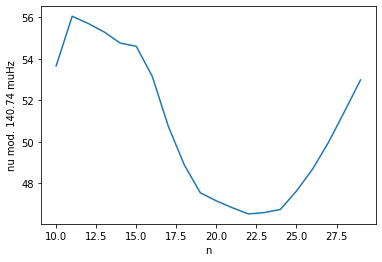

In [8]:
f = 0.96
delta_nu = f*delta_nu_sca
plt.plot(n, nu%delta_nu)
plt.xlabel('n')
plt.ylabel(f'nu mod. {delta_nu:.2f} muHz')

## Simple asymptotics

In [9]:
def linear_model(n, nu=None, nu_err=None):
    delta_nu = numpyro.sample('delta_nu', dist.Normal(141.0, 1.0))
    epsilon = numpyro.sample('epsilon', dist.Normal(1.4, 0.5))
    sigma = numpyro.sample('sigma', dist.HalfNormal(1.0))
    noise = numpyro.sample('noise', dist.HalfNormal(0.1), obs=nu_err)
    
    loc = delta_nu * (n + epsilon)
    scale = jnp.sqrt(sigma**2 + noise**2)
    
    numpyro.sample('nu', dist.Normal(loc, scale), obs=nu)

In [10]:
seed = 42
rng = random.PRNGKey(seed)

In [11]:
rng, key = random.split(rng)

prior_predictive = Predictive(linear_model, num_samples=1000)
prior_pred = prior_predictive(key, n)

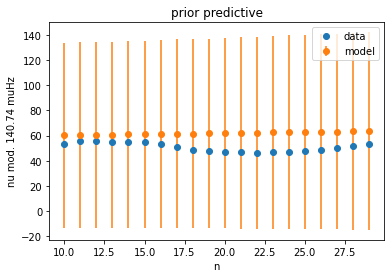

In [12]:
mean = prior_pred['nu'].mean(axis=0)
sd = prior_pred['nu'].std(axis=0)

fig, ax = plt.subplots()
ax.plot(n, nu%delta_nu, marker='o', linestyle='none', label='data')
ax.errorbar(n, mean%delta_nu, yerr=sd, marker='o', linestyle='none', label='model')
ax.set_xlabel('n')
ax.set_ylabel(f'nu mod. {delta_nu:.2f} muHz')
ax.set_title('prior predictive')
ax.legend();

In [13]:
num_warmup = 1000
num_samples = 1000
num_chains = 5

sampler = NUTS(linear_model, target_accept_prob=0.9)
mcmc = MCMC(sampler, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains)

In [14]:
rng, key = random.split(rng)

mcmc.run(key, n, nu=nu, nu_err=0.0)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [15]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  delta_nu    140.38      0.10    140.38    140.21    140.54   1486.37      1.00
   epsilon      1.41      0.02      1.41      1.39      1.44   1497.87      1.00
     sigma      2.53      0.34      2.51      1.97      3.05   1856.22      1.00

Number of divergences: 0


In [16]:
samples = mcmc.get_samples()

In [17]:
rng, key = random.split(rng)

post_predictive = Predictive(linear_model, samples)
post_pred = post_predictive(key, n)

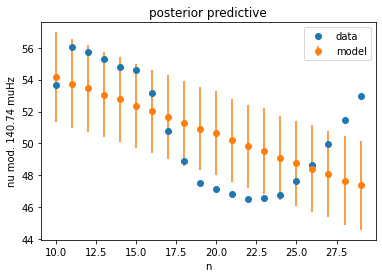

In [18]:
mean = post_pred['nu'].mean(axis=0)
sd = post_pred['nu'].std(axis=0)

fig, ax = plt.subplots()
ax.plot(n, nu%delta_nu, marker='o', linestyle='none', label='data')
ax.errorbar(n, mean%delta_nu, yerr=sd, marker='o', linestyle='none', label='model')
ax.set_xlabel('n')
ax.set_ylabel(f'nu mod. {delta_nu:.2f} muHz')
ax.set_title('posterior predictive')
ax.legend();

What if we use a GP to model the residuals

In [19]:
var = 10.0
length = 5.0

num_draws = 50
num_pred = 250
n_pred = np.linspace(n.min(), n.max(), num_pred)

rng, key = random.split(rng, 2)

kernel = SquaredExponential(var, length)
gp = GP(kernel)
dnu = gp.sample('dnu', n, sample_shape=(num_draws,), rng_key=key)

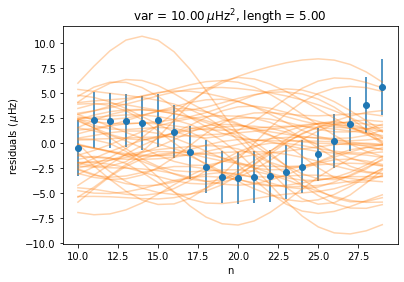

In [20]:
fig, ax = plt.subplots()

plt.errorbar(n, nu - mean, yerr=sd, color='C0', marker='o', linestyle='none')

nn = np.broadcast_to(n, dnu.shape)
ax.plot(nn.T, dnu.T, color='C1', alpha=0.33)

ax.set_xlabel('n')
ax.set_ylabel(r'residuals ($\,\mu\mathrm{Hz}$)')

ax.set_title(f'var = {var:.2f}' + r'$\,\mu\mathrm{Hz}^2$, ' + f'length = {length:.2f}');

## GP model

We know that the acoustic radial modes go as,

$$\nu_{n,l=0} \approx \Delta\nu\,(n + \epsilon)$$

where $\Delta\nu$ is the asymptotic large frequency separation and $\epsilon$ is some offset. The higher order terms are ill-defined. However, we can say that,

$$\nu = \Delta\nu\,(n + \epsilon) + g(n)$$

where we have dropped the $l=0$ and $n$ as it is hereafter implied. The function $g$ may be approximated using a Gaussian process,

$$g(\boldsymbol{n}) \approx \mathcal{GP}\left\{\boldsymbol{0}, k(\boldsymbol{n}, \boldsymbol{n}')\right\}$$

$$\boldsymbol{\nu} \approx \Delta\nu\,(\boldsymbol{n} + \epsilon) + \mathcal{GP}\left\{\boldsymbol{0}, k(\boldsymbol{n}, \boldsymbol{n}')\right\}$$

for a given vector of radial order, $\boldsymbol{n}$. The kernel function, $k(\boldsymbol{n}, \boldsymbol{n}')$, is an estimator of the covarience between $g(\boldsymbol{n})$ and $g(\boldsymbol{n'})$. This is commonly the squared exponential kernel, which takes the following form for element $i, j$ of the resulting matrix,

$$k(n_i, n_j') = \sigma^2 \exp\left[\frac{(n_j' - n_i)^2}{2l^2}\right]$$

where $\sigma^2$ is the variance (or amplitude) and $l$ is the lengthscale of the kernel.

We can absorb the linear component into the GP,

$$\begin{align}
    \boldsymbol{\nu} &= f(\boldsymbol{n})\\
    f(\boldsymbol{n}) &\approx \mathcal{GP}\left\{m(\boldsymbol{n}), k(\boldsymbol{n}, \boldsymbol{n}')\right\}
\end{align}$$

where,

$$m(\boldsymbol{n}) = \Delta\nu\,(\boldsymbol{n} + \epsilon)$$

Let's convert this to a likelihood. If we observe $\boldsymbol{\nu}$ at radial order $\boldsymbol{n}_\mathcal{O}$ with noise $\zeta$, then $\boldsymbol{\nu}_\mathcal{O} = f(\boldsymbol{n}_\mathcal{O}) + \zeta$. Probabilistically, assuming the noise is independent and Gaussian with variance $\sigma_\mathcal{O}^2$,

$$\boldsymbol{\nu}_\mathcal{O}\,|\,\boldsymbol{\theta} \sim \mathcal{N}\left\{\boldsymbol{m}_\mathcal{O}, K_\mathcal{OO} + \sigma_\mathcal{O}^2\mathcal{I}\right\}$$

where $\boldsymbol{\theta}$ are the model parameters, $\boldsymbol{m}_i = m(\boldsymbol{n}_i)$ is the evaluated mean function, $K_{ij} = k(\boldsymbol{n}_i, \boldsymbol{n}_j)$ is the evaluated kernel, and $\mathcal{I}$ is the identity matrix. 

We can make a prediction for the true frequency $\boldsymbol{\nu}$ at positions $\boldsymbol{n}_\mathcal{P}$, $\boldsymbol{\nu}_\mathcal{P} = f(\boldsymbol{n}_\mathcal{P})$, using the joint distribution,

$$\boldsymbol{\nu}_\mathcal{O} , \boldsymbol{\nu}_\mathcal{P}  \,|\,\boldsymbol{\theta} \sim \mathcal{N}\left( \begin{bmatrix} \boldsymbol{m}_\mathcal{O} \\ \boldsymbol{m}_\mathcal{P} \end{bmatrix},  \begin{bmatrix} K_\mathcal{OO}+\sigma_\mathcal{O}^2\mathcal{I} & K_\mathcal{OP} \\ K_\mathcal{OP}^T & K_\mathcal{PP} \end{bmatrix} \right)$$

The conditional probability of $\boldsymbol{\nu}_\mathcal{P}$ given $\boldsymbol{\nu}_\mathcal{O}$ is,

$$p(\boldsymbol{\nu}_\mathcal{P}\,|\,\boldsymbol{\nu}_\mathcal{O}, \boldsymbol{\theta}) = p(\boldsymbol{\nu}_\mathcal{O}\,|\,\boldsymbol{\theta})^{-1} p(\boldsymbol{\nu}_\mathcal{O}, \boldsymbol{\nu}_\mathcal{P}\,|\,\boldsymbol{\theta})$$

Therefore, using the identity for multiplying Gaussians (see eqn. A.7 in Rasmussen & Williams 2006), we get the conditional distribution,

$$\boldsymbol{\nu}_\mathcal{P}\,|\,\boldsymbol{\nu}_\mathcal{O}, \boldsymbol{\theta} \sim \mathcal{N}
\left\{ 
    \boldsymbol{m}_\mathcal{P} + K_\mathcal{OP}\cdot(K_\mathcal{OO} + \sigma_\mathcal{O}^2\mathcal{I})^{-1}\cdot(\boldsymbol{\nu}_\mathcal{O} - \boldsymbol{m}_\mathcal{O}),\,
    K_\mathcal{PP} - K_\mathcal{OP}\cdot(K_\mathcal{OO} + \sigma_\mathcal{O}^2\mathcal{I})^{-1}\cdot K_\mathcal{OP}^T
\right\}$$

In [22]:
from numpyro.primitives import Messenger, apply_stack

class dimension(Messenger):
    """
    """

    def __init__(self, name, size, coords=None, dim=None):
        self.name = name
        self.size = size
        self.dim = -1 if dim is None else dim  # Defaults to rightmost dim
        assert self.dim < 0
        if coords is None:
            coords = np.arange(self.size)
        self.coords = np.array(coords)
        msg = self._get_message()
        apply_stack(msg)
        super().__init__()
    
    def _get_message(self):
        msg = {
            "name": self.name,
            "type": "dimension",
            "dim": self.dim,
            "value": self.coords,
        }
        return msg
        
    def __enter__(self):
        super().__enter__()
        return self._get_message()

    def process_message(self, msg):
        if msg["type"] not in ("param", "sample", "deterministic"):
            # We don't add dimensions to dimensions
            return

        if msg["value"] is None:
            shape = ()
            if "fn" in msg.keys():
                sample_shape = msg["kwargs"].get("sample_shape", ())
                shape = msg["fn"].shape(sample_shape)
        else:
            shape = msg["value"].shape

        if "dims" not in msg.keys():
            dims = [f"{msg['name']}_dim_{i}" for i in range(len(shape))]
            msg["dims"] = dims
        
        if "dim_stack" not in msg.keys():
            msg["dim_stack"] = []
        
        dim = self.dim
        while dim in msg["dim_stack"]:
            dim -= 1

        msg["dim_stack"].append(dim)
        msg["dims"][dim] = self.name
        
        if shape[dim] != self.size:
            raise ValueError(f"Dimension {dim} of site \'{msg['name']}\' should have length {self.size}")

How I want it to work:

```python
asy_prior = LinearAsy(delta_nu=(145.0, 1.0))
he_glitch_prior = HeGlitch(nu_max=(2000., 50.))

    
def model(n, n_pred=None, nu=None, nu_err=None):
    asy_func = asy_prior()
    he_glitch_func = he_glitch_prior()
    
    def mean(n):
        nu_asy = asy_func(n)
        return nu_asy + he_glitch_func(nu_asy)

    noise = ...
    gp = GP(kernel, mean=mean)
    with dimension('n'):
        gp.sample('nu', n, noise=noise, obs=nu)
    
    with dimesion('n_pred'):
        gp.predict('nu_pred', n_pred)
    
    
```

In [ ]:
class Prior:
    def _init_prior(self, value, default_dist=dist.Normal):
        if not isinstance(value, dist.Distribution):
            if not isinstance(value, Iterable):
                value = (value,)
            value = default_dist(*value)
        return value


class LinearAsy(Prior):
    def __init__(self, delta_nu, epsilon=None):
        self.delta_nu = self._init_prior(delta_nu)
        if self.epsilon is None:
            epsilon = (14., 10.)
        self.epsilon = self._init_prior(epsilon)
    
    def __call__(self):
        delta_nu = numpyro.sample('delta_nu', self.delta_nu)
        epsilon = numpyro.sample('epsilon', self.epsilon)
        
        def fn(n):
            return delta_nu * (n + epsilon)
        return fn

linear_asy = LinearAsy((delta_nu, 1.0))


def gp_model(self, n, n_pred=None, nu=None, nu_err=None):
    # Sample prior.
    
    noise = sample('noise', self.noise)
    if nu_err is not None:
        noise = jnp.sqrt(noise**2 + nu_err**2)
#         variance = sample('variance', self.variance)
    length_scale = sample('length_scale', self.length_scale)
    variance = numpyro.param('variance', self.variance)
    # Construct GP
    mean_fn = Linear(delta_nu, epsilon)
    kernel = SquaredExponential(variance, length_scale)
    gp = GP(kernel, mean=mean_fn)

    with dimension('n', n.shape[-1]):
        # Sample GP
        nu = gp.sample('nu', n, noise=noise, obs=nu)
        mean = numpyro.deterministic('mean', mean_fn(n))
        numpyro.deterministic('res', nu - mean)

    if n_pred is not None:
        with dimension('n_pred', n_pred.shape[-1]):
            # Predict with GP
            nu_pred = gp.predict('nu_pred', n_pred)
            mean_pred = numpyro.deterministic('mean_pred', mean_fn(n_pred))
            numpyro.deterministic('res_pred', nu_pred - mean_pred)

In [66]:
def sample(name, value, *args, **kwargs):
    """Alias for numpyro.sample but returns value if not distribution."""
    if not callable(value):
        return value
    return numpyro.sample(name, value, *args, **kwargs)

In [261]:
from functools import partial

In [304]:
class Linear:
    def __init__(self, delta_nu, epsilon):
        self.delta_nu = delta_nu
        self.epsilon = epsilon
    def __call__(self, n):
        return self.delta_nu * (n + self.epsilon)


class GPModel:
    """
    
    Args:
        delta_nu (Iterable or Distribution)
        epsilon (Iterable or Distribution, optional)
        variance (float)

    """
    def __init__(self, delta_nu, epsilon=None, variance=10.0):
        self.delta_nu = delta_nu
        if epsilon is None:
            epsilon = (14., 10.)
        self.epsilon = self._init_prior(epsilon, dist.Gamma)
        self.variance = variance 
        self.length_scale = dist.Gamma(5.0)
        self.noise = dist.HalfNormal(0.1)
    
    def _init_prior(self, value, default_dist=dist.Normal, default_args=()):
        if not isinstance(value, dist.Distribution):
            if not isinstance(value, Iterable):
                value = (value,)
            elif value is None:
                value = default_args
            value = default_dist(*value)
        return value
    
    @property
    def delta_nu(self):
        return self._delta_nu
    
    @delta_nu.setter
    def delta_nu(self, value):
        self._delta_nu = self._init_prior(value)
        
    def __call__(self, n, n_pred=None, nu=None, nu_err=None):
        # Sample prior.
        delta_nu = sample('delta_nu', self.delta_nu)
        epsilon = sample('epsilon', self.epsilon)
        noise = sample('noise', self.noise)
        if nu_err is not None:
            noise = jnp.sqrt(noise**2 + nu_err**2)
#         variance = sample('variance', self.variance)
        length_scale = sample('length_scale', self.length_scale)
        variance = numpyro.param('variance', self.variance)
        # Construct GP
        mean_fn = Linear(delta_nu, epsilon)
        kernel = SquaredExponential(variance, length_scale)
        gp = GP(kernel, mean=mean_fn)
        
        with dimension('n', n.shape[-1]):
            # Sample GP
            nu = gp.sample('nu', n, noise=noise, obs=nu)
            mean = numpyro.deterministic('mean', mean_fn(n))
            numpyro.deterministic('res', nu - mean)

        if n_pred is not None:
            with dimension('n_pred', n_pred.shape[-1]):
                # Predict with GP
                nu_pred = gp.predict('nu_pred', n_pred)
                mean_pred = numpyro.deterministic('mean_pred', mean_fn(n_pred))
                numpyro.deterministic('res_pred', nu_pred - mean_pred)
            
# def gp_model(n, n_pred=None, nu=None, nu_err=None):
#     delta_nu = numpyro.sample('delta_nu', dist.Normal(141.0, 1.0))
#     epsilon = numpyro.sample('epsilon', dist.Normal(1.4, 0.2))
#     noise = numpyro.sample('noise', dist.HalfNormal(0.1), obs=nu_err)

#     def mean(n):
#         return delta_nu[..., None] * (n + epsilon[..., None])

#     var = 10.0
#     length = 5.0
#     kernel = SquaredExponential(var, length)
#     gp = GP(kernel, mean=mean)

#     with dimension('n_obs', n.shape[-1]):
#         nu = gp.sample('nu', n, noise=noise, obs=nu)
#         loc = numpyro.deterministic('mean', mean(n))
#         numpyro.deterministic('dnu', nu - loc)

#     if n_pred is not None:
#         with dimension('n_pred', n_pred.shape[-1]):
#             nu_pred = gp.predict('nu_pred', n_pred)
#             loc_pred = numpyro.deterministic('mean_pred', mean(n_pred))
#             dnu_pred = numpyro.deterministic('dnu_pred', nu_pred - loc_pred)

In [305]:
gp_model = GPModel(
    (delta_nu, 1.0),
    variance=10.0
)
# gp_model = handlers.lift(gp_model, prior={'variance': dist.Gamma(5.0)})

In [306]:
handlers.reparam(gp_model, config={'phi_he': CircularReparam()})

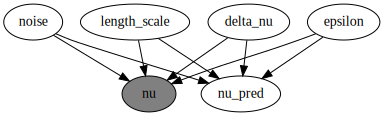

In [307]:
numpyro.render_model(gp_model, model_args=(n, n_pred, nu))

In [265]:
rng, key = random.split(rng)

prior_predictive = Predictive(gp_model, num_samples=1000)
prior_pred = prior_predictive(key, n, n_pred=n_pred)

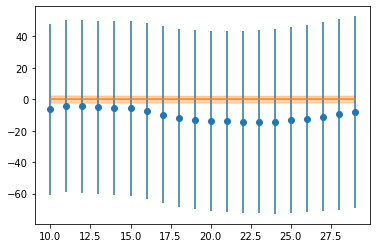

In [266]:
fig, ax = plt.subplots()

# y = nu - mean
dnu = nu - prior_pred['mean'].mean(axis=0)
dnu_err = prior_pred['mean'].std(axis=0)
ax.errorbar(n, dnu, yerr=dnu_err, marker='o', linestyle='none')

dnu_pred = prior_pred['res_pred'].mean(axis=0)
dnu_pred_err = prior_pred['res_pred'].std(axis=0)
ax.plot(n_pred, dnu_pred)
ax.fill_between(n_pred, dnu_pred-dnu_pred_err, dnu_pred+dnu_pred_err, color='C1', alpha=0.33)

In [267]:
init_strategy = init_to_median(num_samples=100)

sampler = NUTS(gp_model, target_accept_prob=0.9, init_strategy=init_strategy)
mcmc = MCMC(sampler, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains)

In [268]:
rng, key = random.split(rng)
mcmc.run(key, n, nu=nu)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [269]:
mcmc.print_summary()


                    mean       std    median      5.0%     95.0%     n_eff     r_hat
      delta_nu    140.76      0.19    140.75    140.44    141.07   1809.51      1.00
       epsilon      1.36      0.03      1.36      1.31      1.41   1773.51      1.00
  length_scale      2.25      0.22      2.24      1.91      2.58   2104.25      1.00
         noise      0.15      0.04      0.15      0.10      0.21   3034.39      1.00
      variance      8.09      2.36      7.74      4.12     11.53   2823.10      1.00

Number of divergences: 0


In [270]:
samples = mcmc.get_samples(group_by_chain=True)

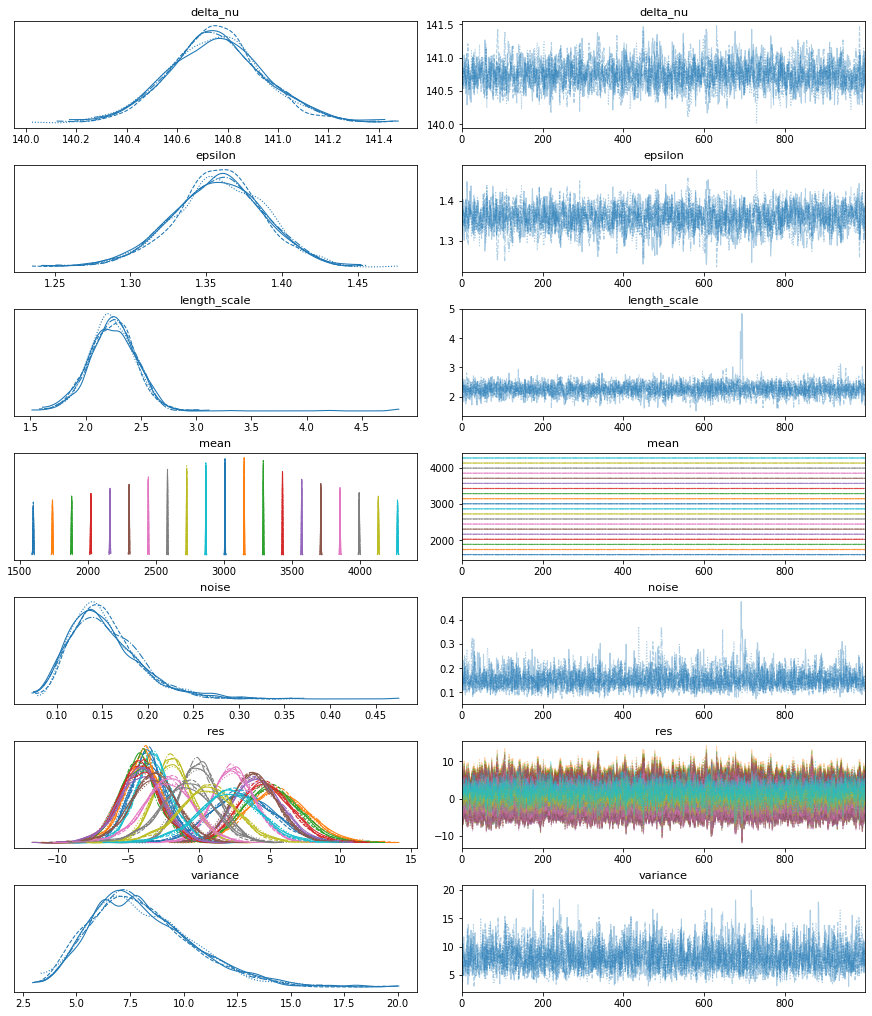

In [271]:
az.plot_trace(samples);

In [227]:
samples = mcmc.get_samples(group_by_chain=False)

In [228]:
rng, key = random.split(rng)

post_predictive = Predictive(gp_model, samples)
post_pred = post_predictive(key, n, n_pred=n_pred, nu=nu)

In [229]:

coords = {}
dims = {}
for k, v in trace.items():
    if v["type"] == "dimension":
        coords[v["name"]] = v["value"]
    elif "dims" in v.keys():
        dims[v["name"]] = v["dims"]

In [ ]:
numpyro.param()

In [230]:
az_trace = az.from_numpyro(mcmc, prior=prior_pred, posterior_predictive=post_pred, coords=coords, dims=dims)

In [244]:
az.from_numpyro()

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

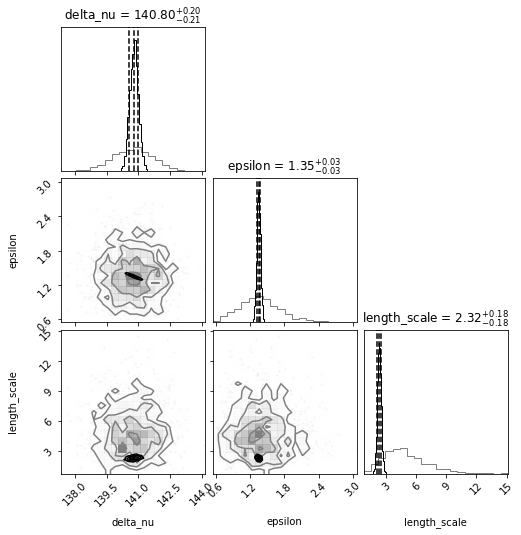

In [231]:
fig = corner(az_trace, var_names=['delta_nu', 'epsilon', 'length_scale'], group='prior', color='grey')
corner(az_trace, var_names=['delta_nu', 'epsilon', 'length_scale'], quantiles=[.16, .5, .84], show_titles=True, fig=fig);

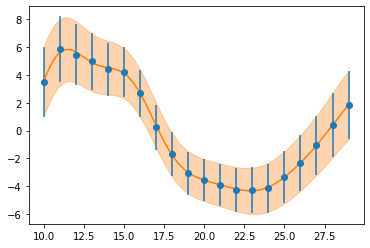

In [232]:
fig, ax = plt.subplots()

dnu = post_pred['res'].mean(axis=0)
dnu_err = post_pred['res'].std(axis=0)
ax.errorbar(n, dnu, yerr=dnu_err, marker='o', linestyle='none')

dnu_pred = post_pred['res_pred'].mean(axis=0)
dnu_pred_err = post_pred['res_pred'].std(axis=0)
ax.plot(n_pred, dnu_pred)
ax.fill_between(n_pred, dnu_pred-dnu_pred_err, dnu_pred+dnu_pred_err, color='C1', alpha=0.33)

In [233]:
rng, key = random.split(rng)

post_pred = post_predictive(key, n, n_pred=n, nu=nu)

Text(0, 0.5, 'residuals')

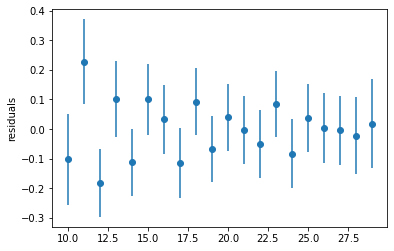

In [234]:
res = post_pred['res'] - post_pred['res_pred']

fig, ax = plt.subplots()

ax.errorbar(n, res.mean(axis=0), yerr=res.std(axis=0), marker='o', linestyle='none')
ax.set_ylabel('residuals')

This is exciting! We can see a decaying oscillation in the residuals!!! We think this is an acoustic glitch.

## Glitch with GP

### Helium glitch

In [76]:
def asy(n, delta_nu, epsilon):
    return delta_nu * (n + epsilon)

def glitch(nu, tau, phi):
    return jnp.sin(4*jnp.pi*tau*nu + phi)

def he_amplitude(nu, a, b):
    return a * nu * jnp.exp(- b * nu**2)

def he_glitch(nu, a, b, tau, phi):
    return he_amplitude(nu, a, b) * glitch(nu, tau, phi)

def glitch_model(n, n_pred=None, nu=None, nu_err=None):
    log_numax = jnp.log10(nu_max_sca)
    
    delta_nu = numpyro.sample('delta_nu', dist.Normal(141.0, 1.0))
    epsilon = numpyro.sample('epsilon', dist.Normal(1.4, 0.2))
    
    _a_he = numpyro.sample("log_a_he", dist.Normal(-1.10 - 0.35*log_numax, 0.5))
    _b_he = numpyro.sample("log_b_he", dist.Normal(0.719 - 2.14*log_numax, 0.5))
    _tau_he = numpyro.sample("log_tau_he", dist.Normal(0.44 - 1.03*log_numax, 0.1))
    
    a_he = numpyro.deterministic("a_he", 10**_a_he)
    b_he = numpyro.deterministic("b_he", 10**_b_he)
    tau_he = numpyro.deterministic('tau_he', 10**_tau_he)

    phi_he = numpyro.sample('phi_he', dist.VonMises(0.0, 0.1))
    
    noise = numpyro.sample('noise', dist.HalfNormal(0.1), obs=nu_err)
    
    def mean(n):
        nu = asy(n, delta_nu, epsilon)
        nu += he_glitch(nu, a_he, b_he, tau_he, phi_he)
        return nu
    
    var = 10.0
    length = 5.0
    kernel = SquaredExponential(var, length)
    gp = GP(kernel, mean=mean)
    
    nu = gp.sample('nu', n, noise=noise, obs=nu)
    loc = numpyro.deterministic('mean', mean(n))
    numpyro.deterministic('res', nu - loc)
    
    nu_asy = numpyro.deterministic('nu_asy', asy(n, delta_nu, epsilon))
    numpyro.deterministic('dnu_he', he_glitch(nu_asy, a_he, b_he, tau_he, phi_he))
    
    if n_pred is not None:
        nu_pred = gp.predict('nu_pred', n_pred)
        loc_pred = numpyro.deterministic('mean_pred', mean(n_pred))
        numpyro.deterministic('res_pred', nu_pred - loc_pred)
        
        nu_asy_pred = numpyro.deterministic('nu_asy_pred', asy(n_pred, delta_nu, epsilon))
        numpyro.deterministic('dnu_he_pred', he_glitch(nu_asy_pred, a_he, b_he, tau_he, phi_he))

In [297]:
class Glitch:
    def __init__(self, tau, phi):
        self.tau = tau
        self.phi = phi
    
    def __call__(self, nu):
        return jnp.sin(4*jnp.pi*self.tau*nu + self.phi)

class HeGlitch(Glitch):
    def __init__(self, a, b, tau, phi):
        self.a = a
        self.b = b
        super().__init__(tau, phi)

    def __call__(self, nu):
        return self.a * nu * jnp.exp(- self.b * nu**2) * super().__call__(nu)


class GPGlitch(GPModel):
    """
    
    Args:
        delta_nu (Distribution or float)
        epsilon (Distribution or float, optional)
        variance (Distribution or float, optional)
        length_scale (Distribution or float, optional)
        noise (Distribution or float, optional)
    """
    def __init__(self, delta_nu, nu_max, epsilon=None, variance=None):
        super().__init__(delta_nu, epsilon=epsilon, variance=variance)
        self.nu_max = nu_max
        
    def __call__(self, n, n_pred=None, nu=None):
        
        # Sample prior.
        delta_nu = sample('delta_nu', self.delta_nu)
        epsilon = sample('epsilon', self.epsilon)
        noise = sample('noise', self.noise)
        variance = sample('variance', self.variance)
        length_scale = sample('length_scale', self.length_scale)
        
        log_numax = jnp.log10(self.nu_max.mean)  # For now use mean only
        _a_he = sample("log_a_he", dist.Normal(-1.10 - 0.35*log_numax, 0.5))
        _b_he = sample("log_b_he", dist.Normal(0.719 - 2.14*log_numax, 0.5))
        _tau_he = sample("log_tau_he", dist.Normal(0.44 - 1.03*log_numax, 0.1))
        phi_he = sample('phi_he', dist.VonMises(0.0, 0.1))
        
        a_he = numpyro.deterministic("a_he", 10**_a_he)
        b_he = numpyro.deterministic("b_he", 10**_b_he)
        tau_he = numpyro.deterministic('tau_he', 10**_tau_he)
        
        # Construct GP
        he_glitch = HeGlitch(a_he, b_he, tau_he, phi_he)
        linear = Linear(delta_nu, epsilon)
        
        def mean_fn(n):
            asy = linear(n)
            return asy + he_glitch(asy)

        kernel = SquaredExponential(variance, length_scale)
        gp = GP(kernel, mean=mean_fn)
        
        with dimension('n_obs', n.shape[-1]):
            # Sample GP
            nu = gp.sample('nu', n, noise=noise, obs=nu)
#             mean = numpyro.deterministic('mean', mean_fn(n))
            nu_asy = numpyro.deterministic('nu_asy', linear(n))
            dnu_he = numpyro.deterministic('dnu_he', he_glitch(nu_asy))

        if n_pred is not None:
            with dimension('n_pred', n_pred.shape[-1]):
                # Predict with GP
                nu_pred = gp.predict('nu_pred', n_pred)
#                 mean_pred = numpyro.deterministic('mean_pred', mean_fn(n_pred))
                nu_asy_pred = numpyro.deterministic('nu_asy_pred', linear(n_pred))
                dnu_he_pred = numpyro.deterministic('dnu_he_pred', he_glitch(nu_asy_pred))

In [298]:
glitch_model = GPGlitch(
    dist.Normal(delta_nu, 1.0),
    dist.Normal(nu_max_sca, 0.05*nu_max_sca),
    dist.Gamma(14., 10.),
)

In [299]:
rng, key = random.split(rng)

prior_predictive = Predictive(glitch_model, num_samples=1000)
prior_pred = prior_predictive(key, n, n_pred=n_pred)

TypeError: unsupported operand type(s) for *: 'NoneType' and 'DynamicJaxprTracer'

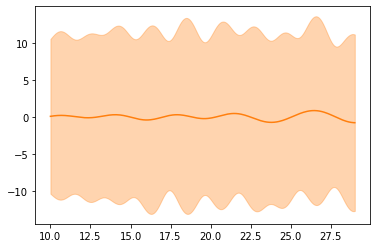

In [154]:
fig, ax = plt.subplots()

# dnu_he = nu - prior_pred['dnu_he'] - prior_pred['nu_asy']
# dnu_he_mean = dnu_he.mean(axis=0)
# dnu_he_sd = dnu_he.std(axis=0)
# dnu_err = prior_pred['mean'].std(axis=0)
# ax.errorbar(n, dnu_he_mean, yerr=dnu_he_sd, marker='o', linestyle='none')

dnu_he_pred = prior_pred['dnu_he_pred'].mean(axis=0)
dnu_he_pred_err = prior_pred['dnu_he_pred'].std(axis=0)
ax.plot(n_pred, dnu_he_pred, color='C1')
ax.fill_between(n_pred, dnu_he_pred-dnu_he_pred_err, dnu_he_pred+dnu_he_pred_err, color='C1', alpha=0.33)

In [155]:
reparam_model = handlers.reparam(
    glitch_model,
    config={
        'phi_he': CircularReparam(),
    },
)

In [156]:
init_strategy = init_to_median(num_samples=100)

sampler = NUTS(reparam_model, target_accept_prob=0.9, init_strategy=init_strategy)
mcmc = MCMC(sampler, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains)

In [157]:
rng, key = random.split(rng)
mcmc.run(key, n, nu=nu)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [158]:
mcmc.print_summary()


                        mean       std    median      5.0%     95.0%     n_eff     r_hat
          delta_nu    140.88      0.24    140.88    140.48    141.25   2199.36      1.00
           epsilon      1.34      0.04      1.34      1.28      1.41   2174.17      1.00
      length_scale      3.88      0.53      3.90      3.02      4.74   1887.35      1.00
          log_a_he     -2.47      0.24     -2.49     -2.84     -2.08   1594.08      1.00
          log_b_he     -6.35      0.11     -6.36     -6.54     -6.17   1794.21      1.00
        log_tau_he     -3.17      0.03     -3.16     -3.20     -3.12   1720.31      1.00
             noise      0.13      0.03      0.13      0.08      0.18   2871.11      1.00
  phi_he_unwrapped     -3.34      6.32     -1.29    -13.66      6.28      2.62      4.79
          variance     11.93      3.23     11.59      6.78     17.11   2900.22      1.00

Number of divergences: 0


In [159]:
samples = mcmc.get_samples(group_by_chain=True)

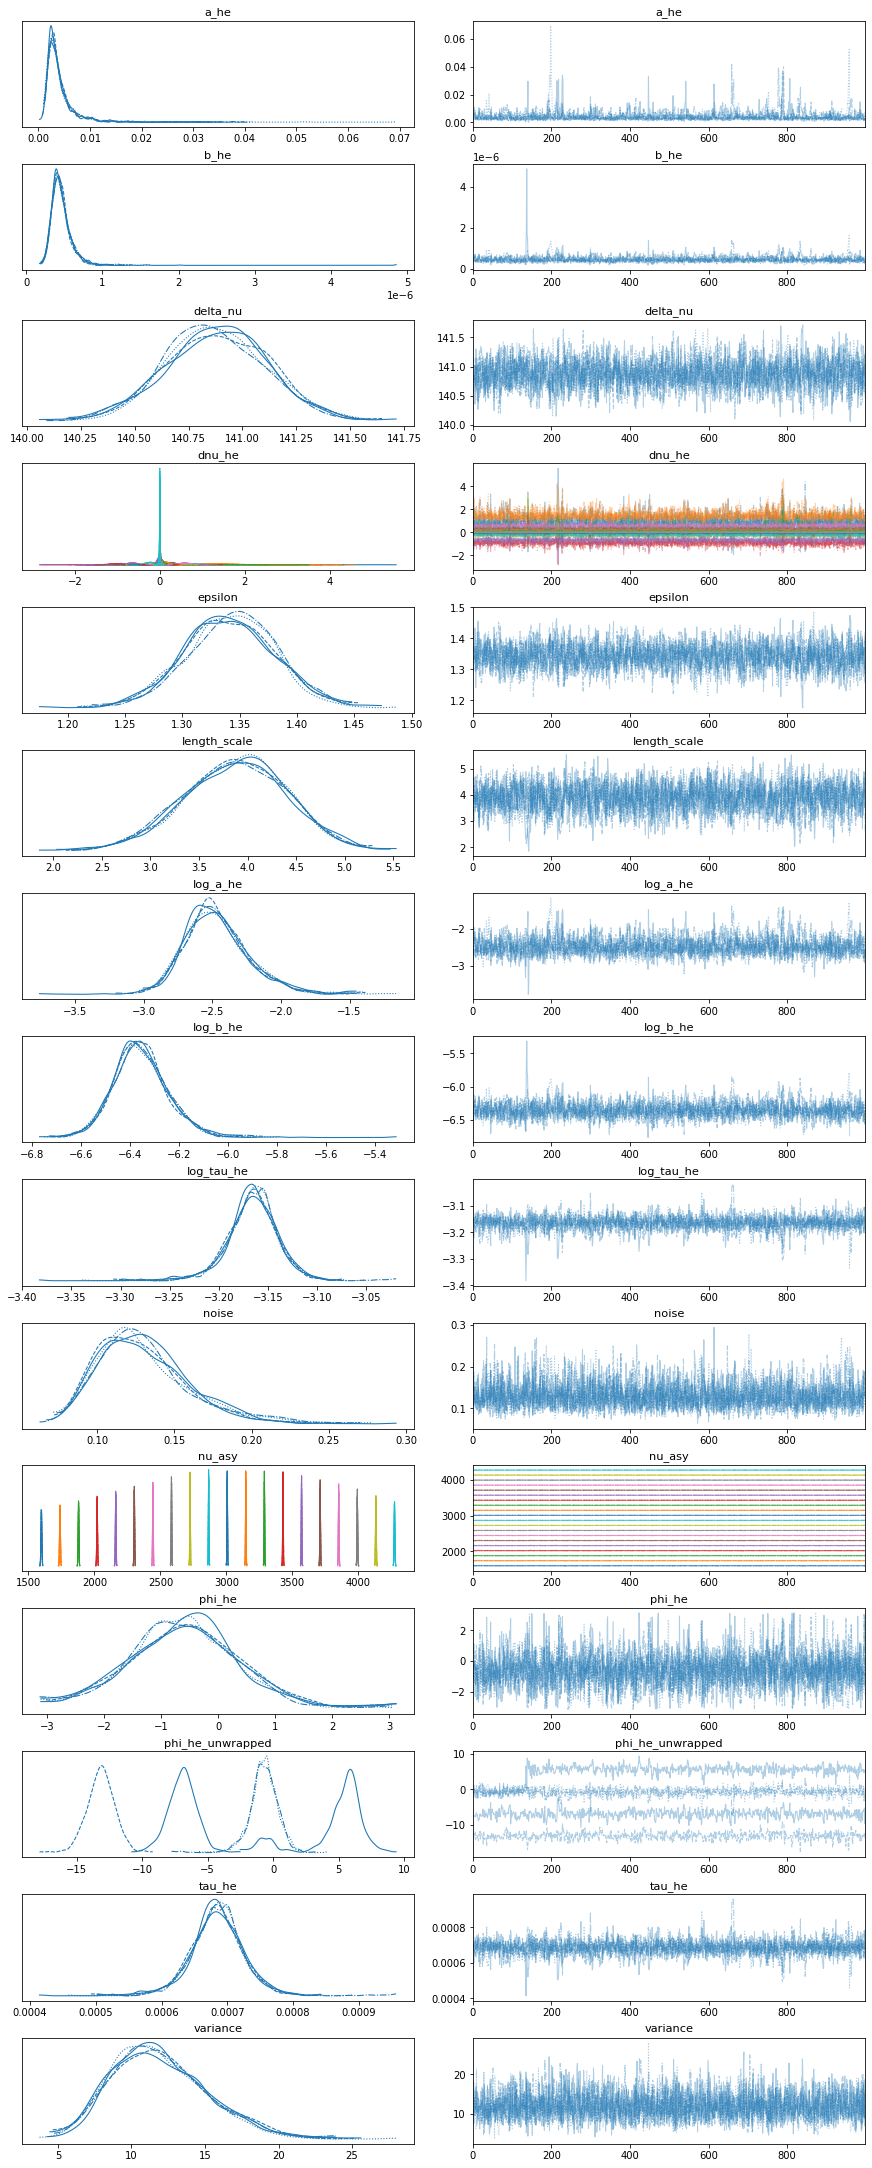

In [160]:
az.plot_trace(samples);

In [161]:
samples = mcmc.get_samples(group_by_chain=False)

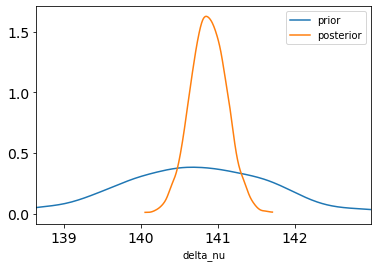

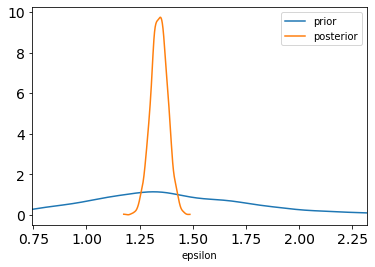

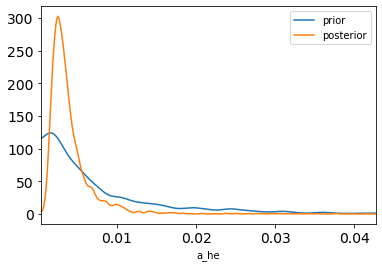

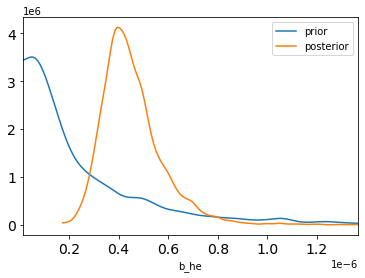

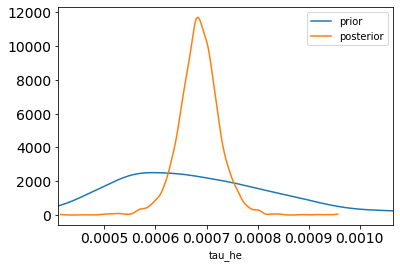

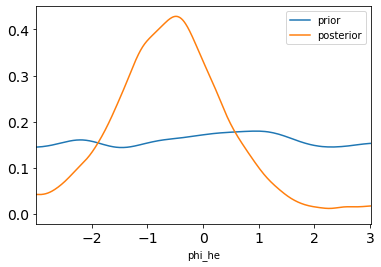

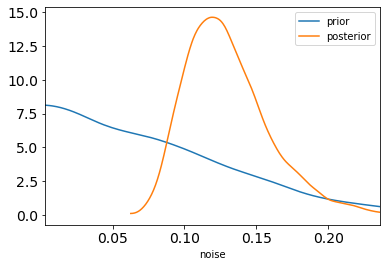

In [162]:
var_names = ['delta_nu', 'epsilon', 'a_he', 'b_he', 'tau_he', 'phi_he', 'noise']

for k in var_names:
    prior_low, prior_up = np.quantile(prior_pred[k].ravel(), [.02, .98])
    post_low, post_up = np.quantile(samples[k].ravel(), [.02, .98])
    lower = np.min([prior_low, post_low])
    upper = np.max([prior_up, post_up])
    
    fig, ax = plt.subplots()
    az.plot_kde(prior_pred[k], ax=ax, label='prior')
    az.plot_kde(samples[k], ax=ax, plot_kwargs={'color': 'C1'}, label='posterior')
    ax.set_xlabel(k)
    ax.legend()
    ax.set_xlim(lower, upper)

In [163]:
rng, key = random.split(rng)

post_predictive = Predictive(glitch_model, samples)
post_pred = post_predictive(key, n, n_pred=n_pred, nu=nu)

In [164]:
n_max = nu_max_sca / samples['delta_nu'] - samples['epsilon']
n_max_mean = n_max.mean(axis=0)
n_max_err = n_max.std(axis=0)

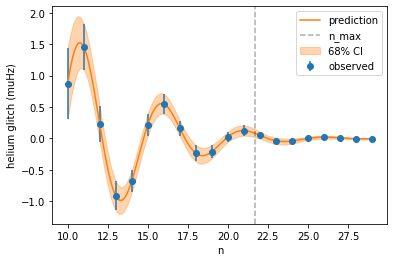

In [165]:
fig, ax = plt.subplots()

dnu_he = post_pred['dnu_he']
dnu_he_mean = dnu_he.mean(axis=0)
dnu_he_sd = dnu_he.std(axis=0)
# dnu_err = prior_pred['mean'].std(axis=0)
ax.errorbar(n, dnu_he_mean, yerr=dnu_he_sd, marker='o', linestyle='none', label='observed')

dnu_he_pred = post_pred['dnu_he_pred'].mean(axis=0)
dnu_he_pred_err = post_pred['dnu_he_pred'].std(axis=0)
ax.plot(n_pred, dnu_he_pred, label='prediction')
ax.fill_between(n_pred, dnu_he_pred-dnu_he_pred_err, dnu_he_pred+dnu_he_pred_err, color='C1', alpha=0.33, label='68% CI')

ax.axvline(n_max_mean, linestyle='--', color='k', alpha=0.33, label='n_max')

ax.legend()
ax.set_xlabel('n')
ax.set_ylabel('helium glitch (muHz)');

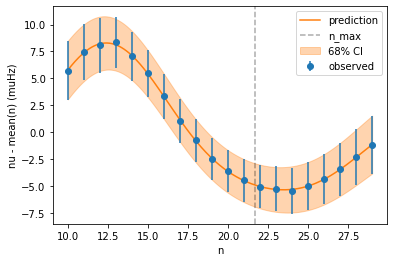

In [45]:
fig, ax = plt.subplots()

res = post_pred['res'].mean(axis=0)
res_err = post_pred['res'].std(axis=0)
ax.errorbar(n, res, yerr=res_err, marker='o', linestyle='none', label='observed')

res_pred = post_pred['res_pred'].mean(axis=0)
res_pred_err = post_pred['res_pred'].std(axis=0)
ax.plot(n_pred, res_pred, label='prediction')
ax.fill_between(n_pred, res_pred-res_pred_err, res_pred+res_pred_err, color='C1', alpha=0.33, label='68% CI')

ax.axvline(n_max_mean, linestyle='--', color='k', alpha=0.33, label='n_max')

ax.set_xlabel('n')
ax.set_ylabel('nu - mean(n) (muHz)')
ax.legend();

In [46]:
rng, key = random.split(rng)

post_pred = post_predictive(key, n, n_pred=n, nu=nu)

Text(0, 0.5, 'residuals')

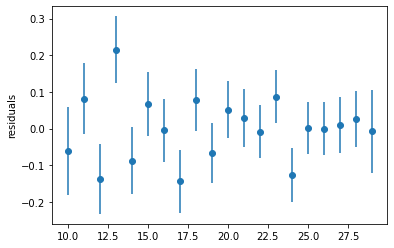

In [47]:
res = post_pred['res'] - post_pred['res_pred']

fig, ax = plt.subplots()

ax.errorbar(n, res.mean(axis=0), yerr=res.std(axis=0), marker='o', linestyle='none')
ax.set_ylabel('residuals')

### Base conv. zone glitch

In [77]:
def cz_amplitude(nu, a):
    return a / nu**2

def cz_glitch(nu, a, tau, phi):
    return cz_amplitude(nu, a) * glitch(nu, tau, phi)

def glitch_model_2(n, n_pred=None, nu=None, nu_err=None):
    log_numax = jnp.log10(nu_max_sca)
    
    delta_nu = numpyro.sample('delta_nu', dist.Normal(141.0, 1.0))
    epsilon = numpyro.sample('epsilon', dist.Normal(1.4, 0.2))
    
    _a_he = numpyro.sample("log_a_he", dist.Normal(-1.10 - 0.35*log_numax, 0.5))
    _b_he = numpyro.sample("log_b_he", dist.Normal(0.719 - 2.14*log_numax, 0.5))
    _tau_he = numpyro.sample("log_tau_he", dist.Normal(0.44 - 1.03*log_numax, 0.1))
    
    a_he = numpyro.deterministic("a_he", 10**_a_he)
    b_he = numpyro.deterministic("b_he", 10**_b_he)
    tau_he = numpyro.deterministic('tau_he', 10**_tau_he)

    phi_he = numpyro.sample('phi_he', dist.VonMises(0.0, 0.1))
    
    _a_cz = numpyro.sample("log_a_cz", dist.Normal(2*log_numax - 1.0, 0.5))
    _tau_cz = numpyro.sample("log_tau_cz", dist.Normal(0.77 - 0.99*log_numax, 0.1))
    
    a_cz = numpyro.deterministic("a_cz", 10**_a_cz)
    tau_cz = numpyro.deterministic("tau_cz", 10**_tau_cz)
    
    phi_cz = numpyro.sample('phi_cz', dist.VonMises(0.0, 0.1))
    
    noise = numpyro.sample('noise', dist.HalfNormal(0.1), obs=nu_err)
    
    def mean(n):
        nu = asy(n, delta_nu, epsilon)
        nu += he_glitch(nu, a_he, b_he, tau_he, phi_he)
        nu += cz_glitch(nu, a_cz, tau_cz, phi_cz)
        return nu
    
    var = 10.0
    length = 5.0
    kernel = SquaredExponential(var, length)
    gp = GP(kernel, mean=mean)
    
    nu = gp.sample('nu', n, noise=noise, obs=nu)
    loc = numpyro.deterministic('mean', mean(n))
    numpyro.deterministic('res', nu - loc)
    
    nu_asy = numpyro.deterministic('nu_asy', asy(n, delta_nu, epsilon))
    numpyro.deterministic('dnu_he', he_glitch(nu_asy, a_he, b_he, tau_he, phi_he))
    numpyro.deterministic('dnu_cz', cz_glitch(nu_asy, a_cz, tau_cz, phi_cz))
    
    if n_pred is not None:
        nu_pred = gp.predict('nu_pred', n_pred)
        loc_pred = numpyro.deterministic('mean_pred', mean(n_pred))
        numpyro.deterministic('res_pred', nu_pred - loc_pred)
        
        nu_asy_pred = numpyro.deterministic('nu_asy_pred', asy(n_pred, delta_nu, epsilon))
        numpyro.deterministic('dnu_he_pred', he_glitch(nu_asy_pred, a_he, b_he, tau_he, phi_he))
        numpyro.deterministic('dnu_cz_pred', cz_glitch(nu_asy_pred, a_cz, tau_cz, phi_cz))

In [78]:
rng, key = random.split(rng)

prior_predictive = Predictive(glitch_model_2, num_samples=1000)
prior_pred = prior_predictive(key, n, n_pred=n_pred)

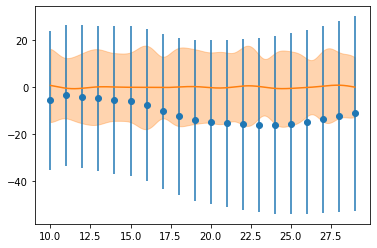

In [79]:
fig, ax = plt.subplots()

dnu_he = nu - (prior_pred['nu_asy'] + prior_pred['res'])
dnu_he_mean = dnu_he.mean(axis=0)
dnu_he_sd = dnu_he.std(axis=0)
# dnu_err = prior_pred['mean'].std(axis=0)
ax.errorbar(n, dnu_he_mean, yerr=dnu_he_sd, marker='o', linestyle='none')

dnu_he_pred = prior_pred['dnu_he_pred'].mean(axis=0)
dnu_he_pred_err = prior_pred['dnu_he_pred'].std(axis=0)
ax.plot(n_pred, dnu_he_pred)
ax.fill_between(n_pred, dnu_he_pred-dnu_he_pred_err, dnu_he_pred+dnu_he_pred_err, color='C1', alpha=0.33)

In [83]:
reparam_model = handlers.reparam(
    glitch_model_2,
    config={
        'phi_he': CircularReparam(),
        'phi_cz': CircularReparam(),
    },
)

In [90]:
init_strategy = init_to_median(num_samples=100)

sampler = NUTS(reparam_model, target_accept_prob=0.95, init_strategy=init_strategy)
mcmc = MCMC(sampler, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains)

In [91]:
rng, key = random.split(rng)
mcmc.run(key, n, nu=nu)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [92]:
mcmc.print_summary()


                        mean       std    median      5.0%     95.0%     n_eff     r_hat
          delta_nu    141.09      0.21    141.08    140.76    141.43   1183.79      1.01
           epsilon      1.31      0.04      1.31      1.25      1.36    884.81      1.01
          log_a_cz      5.85      0.19      5.84      5.65      5.97     28.60      1.15
          log_a_he     -2.64      0.11     -2.63     -2.80     -2.49    114.44      1.04
          log_b_he     -6.44      0.05     -6.44     -6.52     -6.37    139.75      1.04
        log_tau_cz     -2.74      0.09     -2.69     -2.85     -2.67     17.48      1.67
        log_tau_he     -3.17      0.01     -3.17     -3.18     -3.15    749.03      1.01
             noise      0.06      0.03      0.05      0.02      0.10    103.47      1.05
  phi_cz_unwrapped      3.22     44.12      0.86    -84.00     68.67      3.25      3.00
  phi_he_unwrapped     -0.35      0.51     -0.32     -1.02      0.38    835.91      1.01

Number of divergenc

In [104]:
samples = mcmc.get_samples(group_by_chain=True)

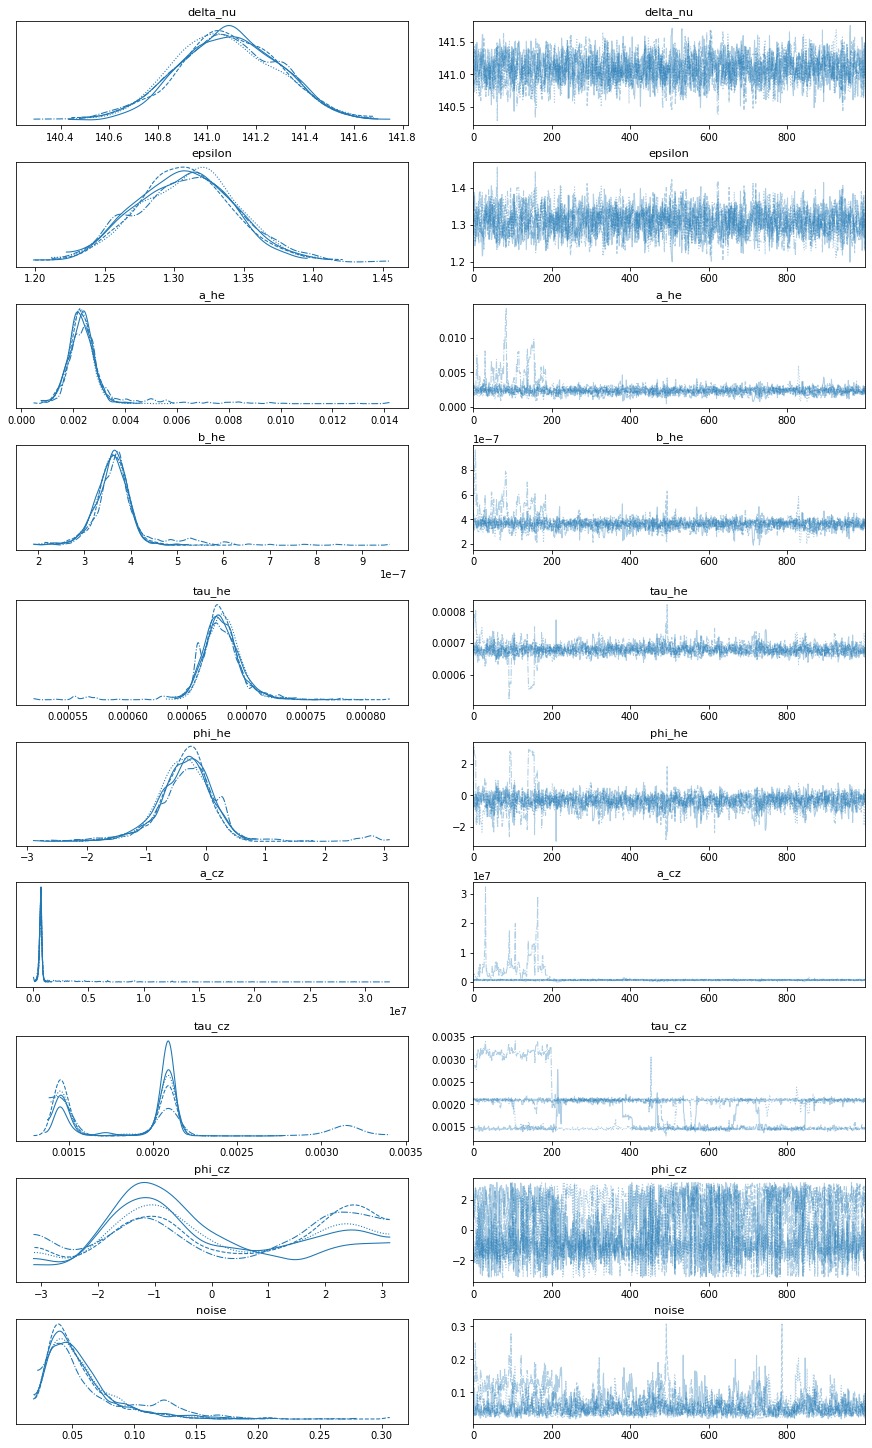

In [106]:
var_names = ['delta_nu', 'epsilon', 'a_he', 'b_he', 'tau_he', 'phi_he', 'a_cz', 'tau_cz', 'phi_cz', 'noise']

az.plot_trace(samples, var_names=var_names);

In [107]:
samples = mcmc.get_samples(group_by_chain=False)

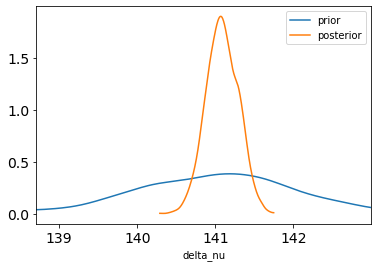

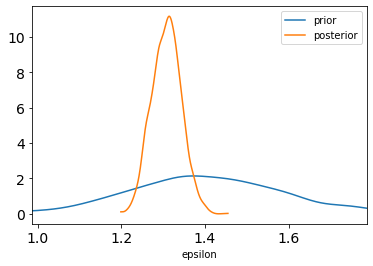

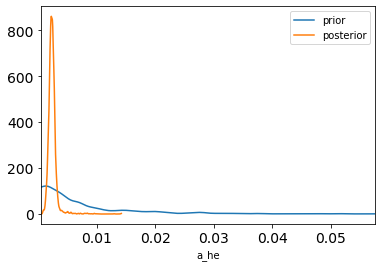

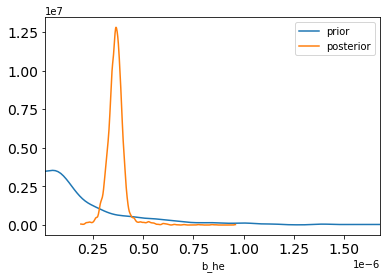

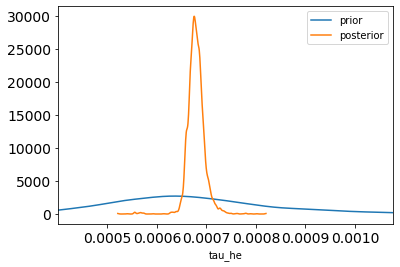

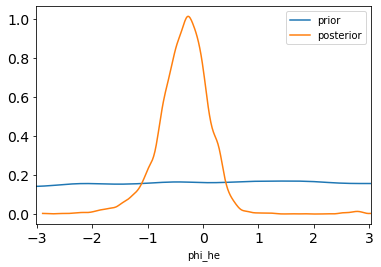

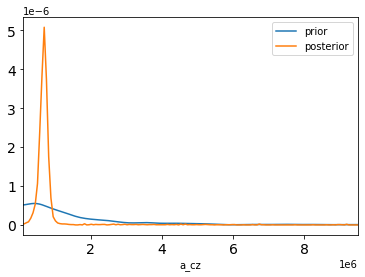

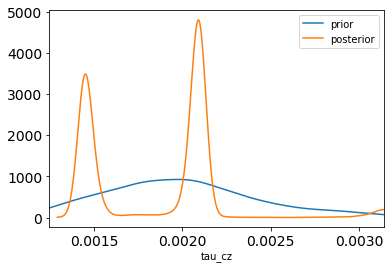

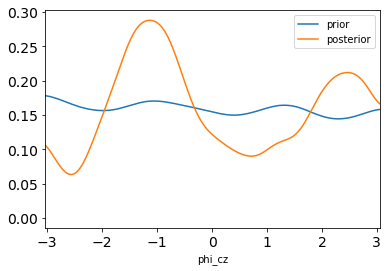

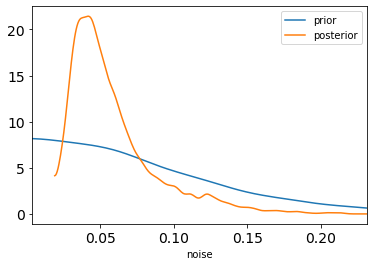

In [108]:
for k in var_names:
    prior_low, prior_up = np.quantile(prior_pred[k].ravel(), [.02, .98])
    post_low, post_up = np.quantile(samples[k].ravel(), [.02, .98])
    lower = np.min([prior_low, post_low])
    upper = np.max([prior_up, post_up])
    
    fig, ax = plt.subplots()
    az.plot_kde(prior_pred[k], ax=ax, label='prior')
    az.plot_kde(samples[k], ax=ax, plot_kwargs={'color': 'C1'}, label='posterior')
    ax.set_xlabel(k)
    ax.legend()
    ax.set_xlim(lower, upper)

In [98]:
rng, key = random.split(rng)

post_predictive = Predictive(glitch_model_2, samples)
post_pred = post_predictive(key, n, n_pred=n_pred, nu=nu)

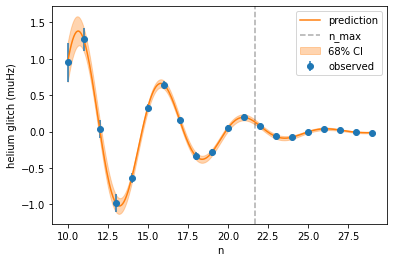

In [99]:
fig, ax = plt.subplots()

dnu_he = post_pred['dnu_he']
dnu_he_mean = dnu_he.mean(axis=0)
dnu_he_sd = dnu_he.std(axis=0)
# dnu_err = prior_pred['mean'].std(axis=0)
ax.errorbar(n, dnu_he_mean, yerr=dnu_he_sd, marker='o', linestyle='none', label='observed')

dnu_he_pred = post_pred['dnu_he_pred'].mean(axis=0)
dnu_he_pred_err = post_pred['dnu_he_pred'].std(axis=0)
ax.plot(n_pred, dnu_he_pred, label='prediction')
ax.fill_between(n_pred, dnu_he_pred-dnu_he_pred_err, dnu_he_pred+dnu_he_pred_err, color='C1', alpha=0.33, label='68% CI')

ax.axvline(n_max_mean, linestyle='--', color='k', alpha=0.33, label='n_max')

ax.legend()
ax.set_xlabel('n')
ax.set_ylabel('helium glitch (muHz)');

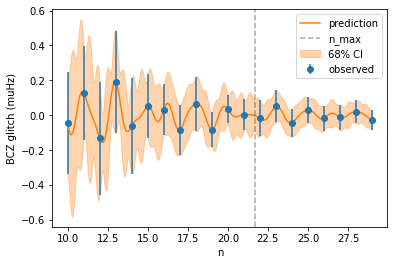

In [101]:
fig, ax = plt.subplots()

dnu_cz = post_pred['dnu_cz']
dnu_cz_mean = dnu_cz.mean(axis=0)
dnu_cz_sd = dnu_cz.std(axis=0)
# dnu_err = prior_pred['mean'].std(axis=0)
ax.errorbar(n, dnu_cz_mean, yerr=dnu_cz_sd, marker='o', linestyle='none', label='observed')

dnu_cz_pred = post_pred['dnu_cz_pred'].mean(axis=0)
dnu_cz_pred_err = post_pred['dnu_cz_pred'].std(axis=0)
ax.plot(n_pred, dnu_cz_pred, label='prediction')
ax.fill_between(n_pred, dnu_cz_pred-dnu_cz_pred_err, dnu_cz_pred+dnu_cz_pred_err, color='C1', alpha=0.33, label='68% CI')

ax.axvline(n_max_mean, linestyle='--', color='k', alpha=0.33, label='n_max')

ax.legend()
ax.set_xlabel('n')
ax.set_ylabel('BCZ glitch (muHz)');

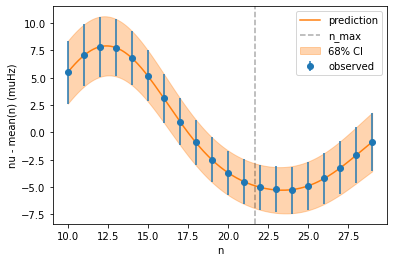

In [102]:
fig, ax = plt.subplots()

res = post_pred['res'].mean(axis=0)
res_err = post_pred['res'].std(axis=0)
ax.errorbar(n, res, yerr=res_err, marker='o', linestyle='none', label='observed')

res_pred = post_pred['res_pred'].mean(axis=0)
res_pred_err = post_pred['res_pred'].std(axis=0)
ax.plot(n_pred, res_pred, label='prediction')
ax.fill_between(n_pred, res_pred-res_pred_err, res_pred+res_pred_err, color='C1', alpha=0.33, label='68% CI')

ax.axvline(n_max_mean, linestyle='--', color='k', alpha=0.33, label='n_max')

ax.set_xlabel('n')
ax.set_ylabel('nu - mean(n) (muHz)')
ax.legend();